# Multiple Runs Analysis

Notebook to test functions for mutiple runs simultaneously.

In [1]:
import nbimporter
import prepData as prep
import fitFunc as fits
import Statistics as stat

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math

import multiprocessing
import time

from scipy.stats import norm

## Table of Contents

1. [Load Dataset](#load) <br>
2. [Preliminary Fits](#fits) <br>
    2.1. [Backgroun Fit](#fits_bkg) <br>
    2.2. [Signal Fit](#fits_sig) <br>
3. [Statistical Analysis](#stats) <br>
    3.1. [Significance](#stats_sign) <br>
    3.2. [Confidence Interval](#stats_ci) <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1  [Complete test](#completeCI) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2  [Multiprocess version](#parallel) <br>

## 1. Load dataset <a name="load"></a>

In [2]:
runsData = prep.Load()

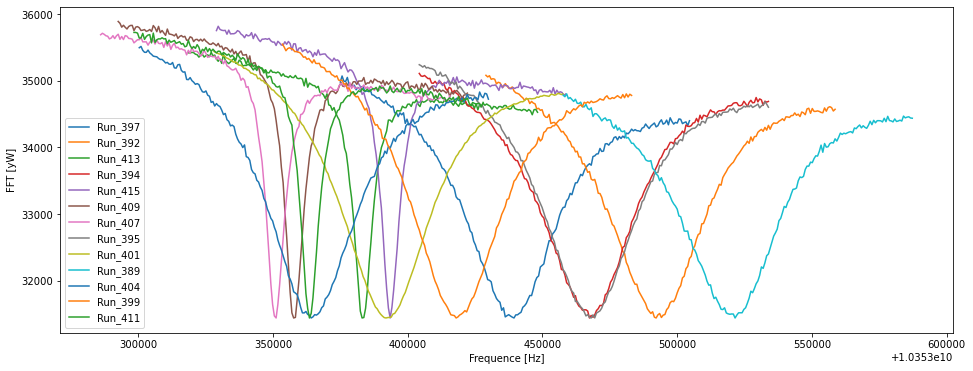

In [3]:
mins=np.empty(len(runsData))
maxs=np.empty(len(runsData))

fig = plt.figure(figsize=(16, 6))

for i_run,run in enumerate(runsData):
    
    runName=run["name"][28:35]
    plt.plot(run["freq"],run["fft"],label=runName)
    plt.xlabel('Frequence [Hz]')
    plt.ylabel('FFT [yW]')
    
plt.legend()
plt.show()

## 2. Preliminary Fits <a name="fits"></a>

### 2.1. Background Fit <a name="fits_bkg"></a>

As a preliminary check, we will fit the background function

$$exp \left( 2 \cdot \frac{|x - a+ib|^2}{|x - c+id|^2} + f \cdot (x - c) \right)$$

and study the distribution of residuals.

In [4]:
fitBkg = fits.multipleFitBKG(runsData)

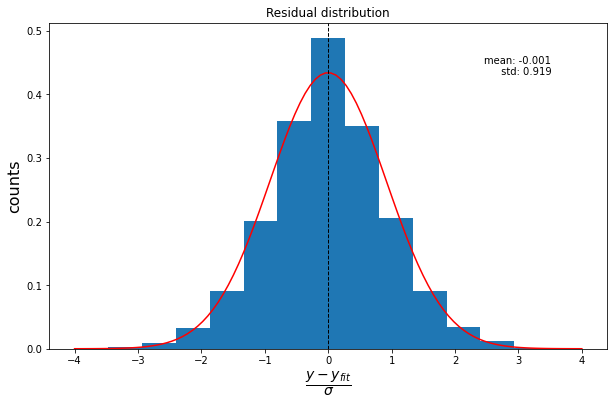

In [5]:
residuals=[]

for i_run,run in enumerate(fitBkg):
    residuals.append(run["bkg_residuals"])

residuals=np.array(residuals).flatten()
rangeMax = int(np.max(residuals))+1

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.hist(residuals,bins=15, density=True, range=(-rangeMax,rangeMax))

fit_res = norm.fit(residuals, loc=0, scale=1)
ax.plot(np.linspace(-rangeMax, rangeMax, 100),
             norm.pdf(np.linspace(-rangeMax, rangeMax, 100), fit_res[0], fit_res[1]), color="red")
ax.axvline(fit_res[0], color='black', linestyle='dashed', linewidth=1)
    
summary_text = "mean: {}\n std: {}".format(np.round(fit_res[0],3), np.round(fit_res[1], 3))
ax.text(0.9, 0.9, summary_text, transform=fig.gca().transAxes, ha='right', va='top')
ax.set_title("Residual distribution")

ax.set_xlabel(r'$\frac{y-y_{fit}}{\sigma}$',size=20)
ax.set_ylabel('counts',size=16)
plt.show()

### 2.1. Signal Fit <a name="fits_sig"></a>

We will now fit the data with a gaussian signal over the background

$$\mu \cdot exp \left( -\frac{1}{2} \frac{(x - x_0)^2}{\sigma^2} \right)$$

using every possible frequency as the centre of the signal $x_0$.

In [6]:
x0=1.035e10+400000
fitSig = fits.multipleFitSIG(runsData, fitBkg, x_0=x0)

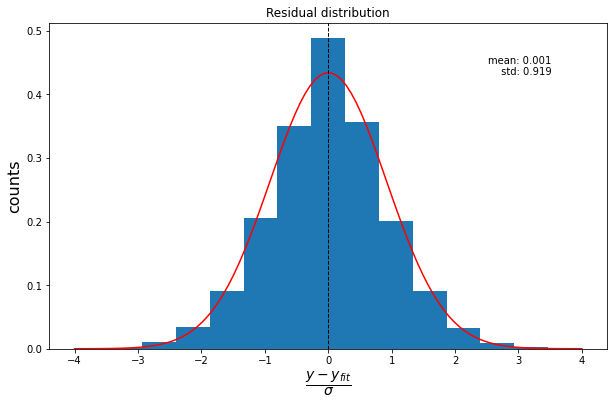

In [7]:
residuals=[]

for i_run,run in enumerate(fitSig):
    residuals.append(run["sig_residuals"]/run["weights"])

residuals=np.array(residuals).flatten()
rangeMax = int(np.max(residuals))+1

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.hist(residuals,bins=15, density=True, range=(-rangeMax,rangeMax))

fit_res = norm.fit(residuals, loc=0, scale=1)
ax.plot(np.linspace(-rangeMax, rangeMax, 100),
             norm.pdf(np.linspace(-rangeMax, rangeMax, 100), fit_res[0], fit_res[1]), color="red")
ax.axvline(fit_res[0], color='black', linestyle='dashed', linewidth=1)
    
summary_text = "mean: {}\n std: {}".format(np.round(fit_res[0],3), np.round(fit_res[1], 3))
ax.text(0.9, 0.9, summary_text, transform=fig.gca().transAxes, ha='right', va='top')
ax.set_title("Residual distribution")
ax.set_xlabel(r'$\frac{y-y_{fit}}{\sigma}$',size=20)
ax.set_ylabel('counts',size=16)

plt.show()

## 3. Statistical Analysis <a name="stats"></a>

### 3.1. Significance <a name="stats_sign"></a>

Assuming the presence of a signal, we will now compute its significance. As more thoroughly explained in the "Statistics" notebook, this quantity is computed from the p-value of the observed likelihood ratio

$$q_0^{obs} = -2 \cdot \log \left( \cfrac{\mathcal{L} \left(Data | 0, \hat{\theta}_0 \right)}{\mathcal{L} \left(Data | \hat{\mu}, \hat{\theta}_\hat{\mu} \right)}\right)$$

with respect to a distribution ob of $q_0$ obtained from toy datasets.  
Every recorded frequency is investigated as a possible center of the signal, $x_0$. 

In [9]:
all_freq=np.linspace(10353286068+16*651, 10353286068+31*16*651,30)

signif_x0=all_freq[range(0,28,5)]

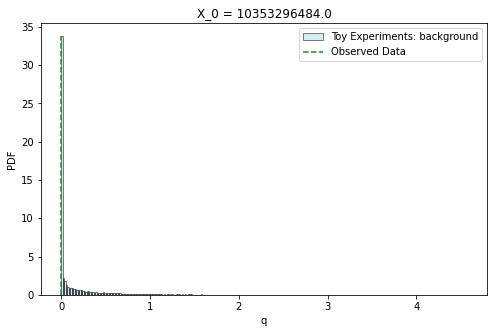

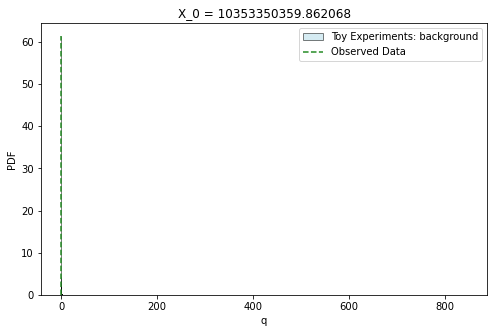

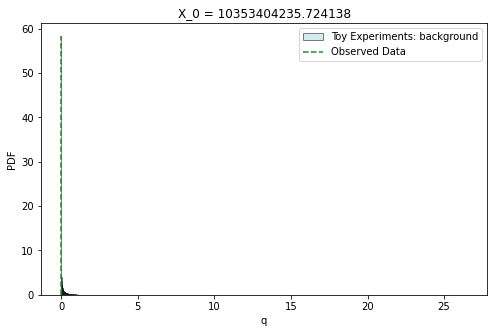

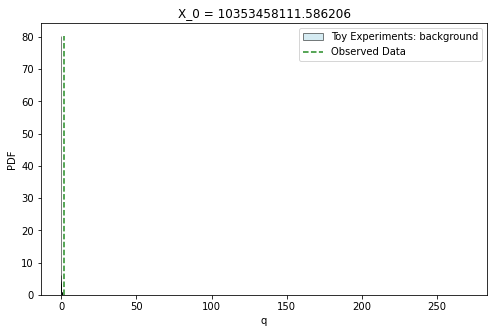

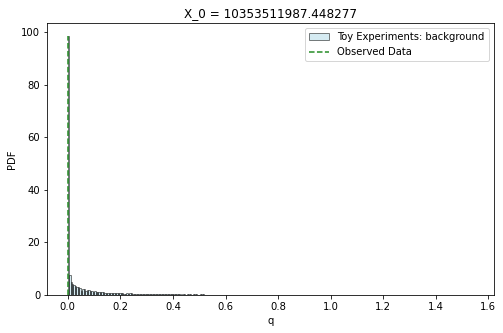

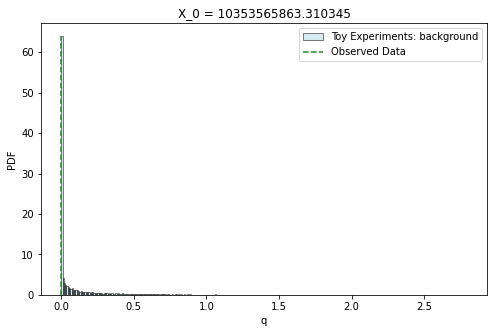

In [10]:
z,_=stat.stat_test(runsData,signif_x0,nToy=10000,calc_CI=False,calc_z=True,verbose=True,draw=True)

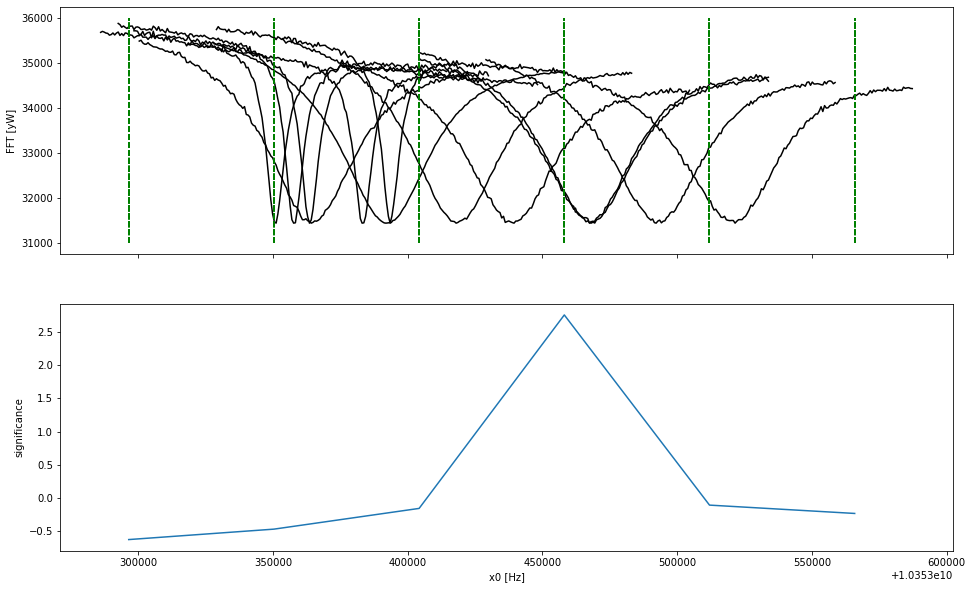

In [11]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")
    ax[0].vlines(signif_x0,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(signif_x0,z)

ax[0].set_ylabel("FFT [yW]")
ax[1].set_xlabel("x0 [Hz]")
ax[1].set_ylabel("significance")
plt.show()

### 3.2. Confidence Interval <a name="stats_ci"></a>

We are now interested in setting a limit on the strength of the signal, thus computing $\mu^{95\% CL}$. It would not be correct *a priori* to do both this and the previous staistical test, as they start from different assumptions on the presence of the signal or lack thereof; we will still be showing both for a more complete discussion. 

```python
x0_partial=all_freq[range(0,5)]
muCL1=stat.stat_test(runsData,x0_partial,mu_fix=10,verbose=True,draw=True)
```

#### 3.2.1. Complete test <a name="completeCI"></a>

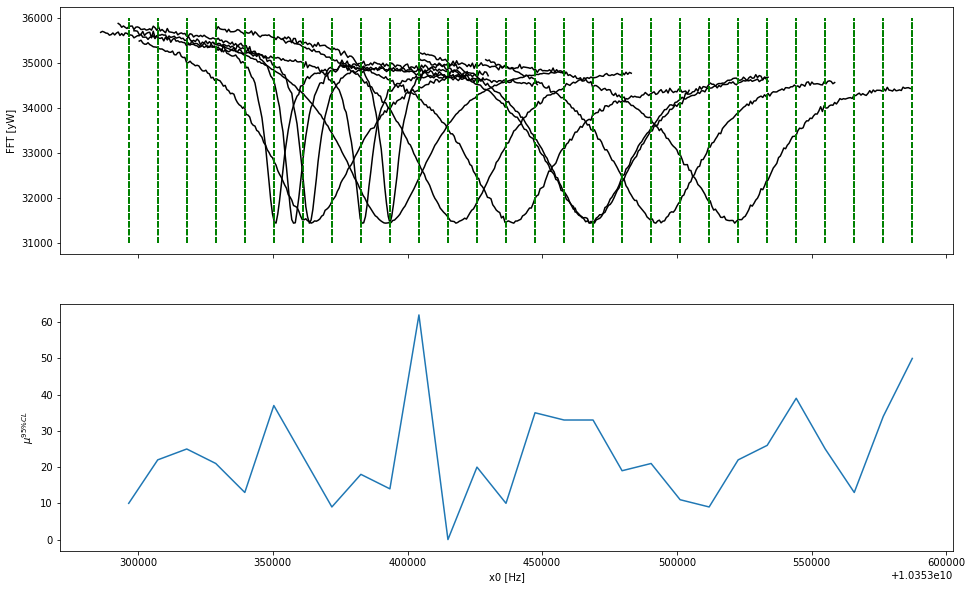

In [33]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

x0 = all_freq[range(0,28)]
muCL = np.array([10,22,25,21,13,37,23,9,18,14,62,0,20,10,35,33,33,19,21,11,9,22,26,39,25,13,34,50])

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")
    ax[0].vlines(x0,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0,muCL)

ax[0].set_ylabel("FFT [yW]")
ax[1].set_xlabel("x0 [Hz]")
ax[1].set_ylabel(r'$\mu^{95\%CL}$')
plt.show()

#### 3.2.2. Multiprocess version <a name="parallel"></a>

The introduction of a multiprocessing version of the code stems from the substantial computational effort required by this procedure. By leveraging the results obtained from the standard version of the code (see "mu_init" list), we can facilitate parallelization using the multiprocess Python library. This enhancement aims to significantly improve the code's overall performance.

```python
all_freq=np.linspace(10353286068+16*651, 10353286068+31*16*651,30)
mu_init=[10,13,21,30,20,20]
runsData = prep.Load()
muCI_results=stat_test_parallel(runsData,all_freq,mu_init,len(mu_init))
```

In [40]:
result_final=np.array([[1.03532965e+10, 8.00000000e+00, 8.62944162e-02],
       [1.03533073e+10, 2.20000000e+01, 5.03951555e-02],
       [1.03533180e+10, 2.50000000e+01, 5.91597313e-02],
       [1.03533288e+10, 2.20000000e+01, 3.99559383e-02],
       [1.03533396e+10, 1.30000000e+01, 5.67639874e-02],
       [1.03533504e+10, 3.30000000e+01, 7.34042553e-01],
       [1.03533611e+10, 2.50000000e+01, 2.50000000e-01],
       [1.03533719e+10, 8.00000000e+00, 4.20253165e-02],
       [1.03533827e+10, 1.80000000e+01, 7.35414117e-02],
       [1.03533935e+10, 1.50000000e+01, 7.85969471e-02],
       [1.03534042e+10, 5.80000000e+01, 5.96330275e-02],
       [1.03534150e+10, 2.00000000e+01, 1.40000000e-01],
       [1.03534258e+10, 2.50000000e+01, 1.05000000e+01],
       [1.03534366e+10, 8.00000000e+00, 5.70440795e-02],
       [1.03534473e+10, 3.40000000e+01, 6.07551717e-02],
       [1.03534581e+10, 3.30000000e+01, 3.02239181e-02],
       [1.03534689e+10, 3.30000000e+01, 5.83882413e-02],
       [1.03534797e+10, 1.90000000e+01, 5.34889687e-02],
       [1.03534904e+10, 2.10000000e+01, 4.16731944e-02],
       [1.03535012e+10, 1.10000000e+01, 4.25531915e-02],
       [1.03535120e+10, 9.00000000e+00, 4.67289720e-02],
       [1.03535228e+10, 2.20000000e+01, 4.01937046e-02],
       [1.03535335e+10, 2.60000000e+01, 5.20471895e-02],
       [1.03535443e+10, 3.90000000e+01, 4.34968473e-02],
       [1.03535551e+10, 2.50000000e+01, 4.32832474e-02],
       [1.03535659e+10, 1.50000000e+01, 4.01785714e-02],
       [1.03535766e+10, 3.40000000e+01, 4.55927052e-02],
       [1.03535874e+10, 5.00000000e+01, 5.22736365e-02]])

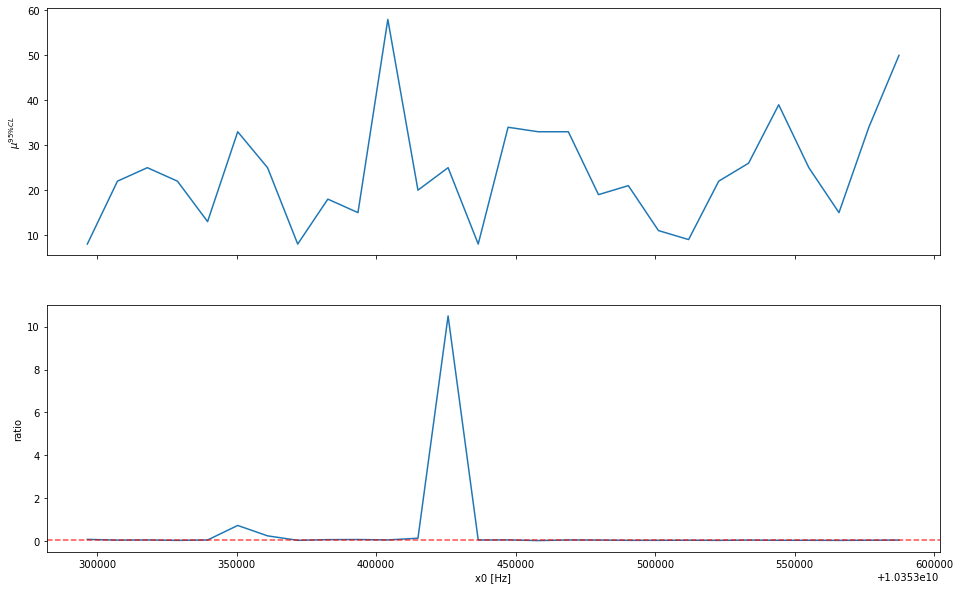

In [50]:
fig,ax=plt.subplots(2,1,figsize=(16,10),sharex=True)

ax[0].plot(result_final[:28,0], result_final[:28,1])
ax[0].set_ylabel(r'$\mu^{95\%CL}$')

ax[1].plot(result_final[:28,0], result_final[:28,2])
ax[1].axhline(0.05, color='red',linestyle="dashed",alpha=0.7)
ax[1].set_ylabel('ratio')
ax[1].set_xlabel('x0 [Hz]')

plt.show()